# Database Connection - Linear Regression

## Outline:
* connect to Postgres Database in AWS.
* load economic features and target table into Dataframe
* additional Data manipulation in Dataframe
* train model and evaluate results

## Import Dependencies
* config.py file is needed to connect to AWS database


### You may need to run these pip install in the correct conda environment: 
$ pip install psycopg2

$ pip install psycopg2-binary

In [1]:
# Import database dependencies
from sqlalchemy import inspect, create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import config as creds

# Import Pandas and matplotlib dependencies
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt

# Import scikit packages
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
import sklearn.datasets as datasets
# For splitting of data into train and test set
from sklearn.model_selection import train_test_split
# Metrics for Evaluation of model Accuracy and F1-score
from sklearn.metrics  import f1_score,accuracy_score
import sklearn.metrics as metrics

In [2]:
#!pip install psycopg2

In [3]:
#!pip install psycopg2-binary 

## Connect to postgres database in AWS, read data into a Dataframe¶

In [4]:
# Create engine
engine = create_engine(f'postgresql://{creds.PGUSER}:{creds.PGPASSWORD}@{creds.PGHOST}:5432/{creds.PGDATABASE}')

In [5]:
# Create our session (link) from Python to the DB
session = Session(bind=engine.connect())

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# List tables in database
inspect(engine).get_table_names()

['high_low_poverty',
 'ave_wage_indexing',
 'welfare_education',
 'economic_features_full',
 'economic_features',
 'lowest_poverty_rates',
 'highest_poverty_rates',
 'cpi_inflation_rate',
 'crime_rate',
 'divorce_rate',
 'homeownership_rate',
 'min_wage_effective',
 'poverty_rates',
 'unemployment_rate']

In [27]:
# List columns in a specific table
[column['name'] for column in inspect(engine).get_columns('economic_features')]

['year',
 'state',
 'population_million',
 'education_million',
 'welfare_million',
 'crime_rate',
 'unemployment_rate',
 'divorce_rate_per_1000_people',
 'homeownership_rate',
 'minimum_wage_effective',
 'cpi_average',
 'inflation_rate',
 'avg_wage_index',
 'poverty_rate']

In [8]:
# List columns in a specific table 
[column['name'] for column in inspect(engine).get_columns('economic_features_full')]

['year',
 'state',
 'population_million',
 'education_million',
 'welfare_million',
 'crime_rate',
 'unemployment_rate',
 'divorce_rate_per_1000_people',
 'homeownership_rate',
 'minimum_wage_effective',
 'cpi_average',
 'inflation_rate',
 'avg_wage_index',
 'poverty_rate']

In [9]:
# Defining function that takes in a table name and outputs a dataframe
def db_reader(tablename):
    table_df = pd.read_sql_table(f'{tablename}', engine)
    return table_df

In [28]:
# Reading a database table into a dataframe
econ_features_full = db_reader('economic_features_full')
econ_features_full.head()

,year,state,population_million,education_million,welfare_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate
0,1970,National,203.302,56456.0,18738.8,363.5,NaN,3.50,NaN,1.382353,38.8,5.8,6186.24,17.18
1,1971,National,205.515,63469.0,27364.3,396.0,NaN,3.75,NaN,1.382353,40.5,4.3,6497.08,17.05
2,1972,National,207.752,71351.0,30594.3,401.0,NaN,4.00,NaN,1.623529,41.8,3.3,7133.80,16.12
3,1973,National,210.013,75849.0,28944.9,417.4,NaN,4.25,NaN,1.623529,44.4,6.2,7580.16,15.13
4,1974,National,212.299,81440.0,34816.4,461.1,NaN,4.50,NaN,1.623529,49.3,11.1,8030.76,15.86


In [32]:
econ_features_full.dtypes

year                              int64
state                            object
population_million              float64
education_million               float64
welfare_million                 float64
crime_rate                      float64
unemployment_rate               float64
divorce_rate_per_1000_people    float64
homeownership_rate              float64
minimum_wage_effective          float64
cpi_average                     float64
inflation_rate                  float64
avg_wage_index                  float64
poverty_rate                    float64
dtype: object

In [29]:
econ_features_full.describe()

,year,population_million,education_million,welfare_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate
count,2964.000000,2964.000000,2.964000e+03,2.964000e+03,2584.000000,2340.000000,2600.000000,1924.000000,2652.000000,2652.000000,2704.000000,2652.000000,2060.000000
mean,1998.000000,10.594938,2.225726e+04,9.389528e+03,435.670279,5.938875,4.163200,67.269418,4.766336,149.718275,3.955769,27328.000588,16.011718
std,16.454726,37.865413,1.032112e+05,6.274371e+04,263.830217,2.081335,0.713196,6.452384,2.280135,67.152559,2.839499,14577.283930,4.639917
min,1970.000000,0.303000,1.199000e+02,1.280000e+01,34.200000,2.100000,2.700000,34.600000,1.300000,38.800000,-0.400000,6186.240000,7.300000
25%,1984.000000,1.570750,1.931550e+03,5.900000e+02,265.275000,4.400000,3.600000,64.900000,3.350000,96.500000,2.175000,14531.340000,12.700000
50%,1998.000000,3.821500,4.919800e+03,1.313950e+03,389.500000,5.600000,4.225000,68.500000,4.250000,152.400000,3.200000,24705.660000,15.300000
75%,2012.000000,6.632750,1.372025e+04,3.561275e+03,551.350000,7.200000,4.755600,71.200000,6.750000,214.537000,4.800000,40711.610000,18.525000
max,2026.000000,343.192000,1.533802e+06,1.803767e+06,2921.800000,17.300000,5.300000,81.300000,14.000000,258.660000,13.500000,54640.990000,33.590000


In [30]:
len(econ_features_full)

2964

## Additional data processing¶

In [12]:
# Drop the non-beneficial columns
model_df = econ_features_full.drop(columns=["year", "divorce_rate_per_1000_people", "crime_rate"], axis=1).dropna()
model_df.head()

# # Jose's code
# # Drop the non-beneficial columns
# columns_to_drop = ['education_million','welfare_million']
# model_df = econ_features_full.drop(columns=columns_to_drop, axis=1)

# # Drop 'District of Columbia' information
# model_df.drop(model_df[model_df['state']=='District of Columbia'].index, inplace=True)

# model_df.head()

,state,population_million,education_million,welfare_million,unemployment_rate,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate
14,National,235.164,191925.0,143711.9,7.637412,64.5,3.360196,103.9,4.3,16135.07,16.04
15,National,237.369,209227.0,165441.6,7.304109,63.9,3.360196,107.6,3.5,16822.51,15.72
16,National,239.595,227705.0,159050.4,7.096872,63.8,3.360196,109.6,1.9,17321.82,15.20
17,National,241.842,242694.0,167313.2,6.297189,64.0,3.360196,113.6,3.7,18426.51,14.48
18,National,244.110,260024.0,176861.6,5.589161,63.8,3.409804,118.3,4.1,19334.04,14.81


In [13]:
model_df.describe()

,population_million,education_million,welfare_million,unemployment_rate,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate
count,1586.000000,1.586000e+03,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000
mean,11.906674,2.495013e+04,10587.069294,5.812309,67.966683,5.161873,169.748974,2.834615,30535.298253,15.185706
std,42.104500,1.046810e+05,52732.456113,1.936079,5.351736,1.482549,40.447857,1.137070,9478.768205,4.470417
min,0.454000,4.505000e+02,122.500000,2.100000,50.200000,3.350000,103.900000,-0.400000,16135.070000,7.300000
25%,1.744500,2.814925e+03,801.675000,4.400000,65.400000,3.850000,136.200000,2.100000,21811.600000,11.900000
50%,4.045000,6.318600e+03,1622.700000,5.500000,68.700000,5.150000,166.600000,2.900000,30469.840000,14.415000
75%,6.596000,1.355342e+04,4043.075000,6.900000,71.500000,6.500000,207.342000,3.500000,40405.480000,17.300000
max,328.330000,1.182912e+06,670696.900000,14.100000,81.300000,9.320000,255.657000,5.400000,54099.990000,33.590000


In [14]:
model_df.apply(lambda x: sum(x.isnull()))

state                     0
population_million        0
education_million         0
welfare_million           0
unemployment_rate         0
homeownership_rate        0
minimum_wage_effective    0
cpi_average               0
inflation_rate            0
avg_wage_index            0
poverty_rate              0
dtype: int64

In [15]:
# # Define X and y variables
X = model_df.loc[model_df["state"] == "Texas"].drop(["poverty_rate", "state"], axis=1)#.values.reshape(-1, 1)
y = model_df.loc[model_df["state"] == "Texas"]["poverty_rate"]

# Below code is Jose's code added
# # Pick data for 1 state
# state_to_model = 'National'
# model_state_df = model_df.loc[model_df['state']==state_to_model].dropna().set_index('year')
# model_state_df.drop(columns=['state'], inplace=True)
# model_state_df

# # Define X and y variables
# X = model_state_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
# y = model_state_df["poverty_rate"]
# print(f'X shape: {X.shape}')
# X.head()

In [16]:
X.head()

,population_million,education_million,welfare_million,unemployment_rate,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index
2522,15.274,12859.1,3082.9,6.1,62.5,3.35,103.9,4.3,16135.07
2523,15.547,14235.5,3196.9,7.0,60.5,3.35,107.6,3.5,16822.51
2524,15.825,15609.0,3544.8,8.8,61.0,3.35,109.6,1.9,17321.82
2525,16.108,15930.8,4390.2,8.5,61.1,3.35,113.6,3.7,18426.51
2526,16.395,16739.6,4341.6,7.4,59.9,3.35,118.3,4.1,19334.04


In [17]:
X.shape

(31, 9)

In [18]:
model_df.dtypes

state                      object
population_million        float64
education_million         float64
welfare_million           float64
unemployment_rate         float64
homeownership_rate        float64
minimum_wage_effective    float64
cpi_average               float64
inflation_rate            float64
avg_wage_index            float64
poverty_rate              float64
dtype: object

In [19]:
# Standardize data
import sklearn.preprocessing as preprocessing

std = preprocessing.StandardScaler()
# X is a matrix
std.fit(X)
X_std = std.transform(X)



In [20]:
#Split the dataset into training and testing sets 
#from sklearn.model_selection import train_test_split

#No need to split the traiing and testing data set for linear regression
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [21]:
# Create a model with scikit-learn
model = LinearRegression()

In [22]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [23]:
# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)
print(X.shape)


# for regression we use R2 score and MAE(mean absolute error)
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# print(r2_score(y,y_pred))
# print(mean_absolute_error(y,y_pred))

       
       
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
print(f'Mean absolute error: {mean_absolute_error(y,y_pred)}')
print(f'Mean square error: {mean_squared_error(y,y_pred)}')
print(f'r2 score: {r2_score(y,y_pred)}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

(31,)
(31, 9)
Mean absolute error: 0.181233339993234
Mean square error: 0.05416587804742238
r2 score: 0.9909303558267432
Coefficients: [ 1.47475567e+00 -4.99301241e-07 -1.42169208e-04  4.58611418e-01
 -1.85708389e-01 -8.89354548e-01 -8.73572585e-02  3.19363688e-01
 -2.10580011e-04]
Intercept: 22.750016949180782


In [24]:
# Check r squared value
r_squared = r2_score(y, y_pred)
print(f'R-Squared value: {r_squared}')

R-Squared value: 0.9909303558267432


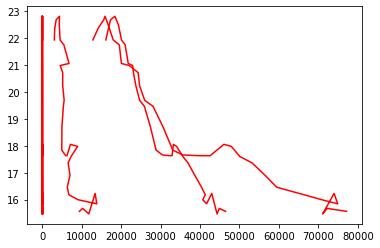

In [25]:
# Plot the results. The best fit line is red.

plt.plot(X, y_pred, color='red')
plt.show()

In [26]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[ 1.47475567e+00 -4.99301241e-07 -1.42169208e-04  4.58611418e-01
 -1.85708389e-01 -8.89354548e-01 -8.73572585e-02  3.19363688e-01
 -2.10580011e-04]
22.750016949180782
